# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
population = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
features = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
# Print the shape and the first 3 rows of the population DataFrame
print("First 3 rows of Population:")
display(population.head(3))
print("Population shape:", population.shape)

# Print the shape and the first 3 rows of the features DataFrame
print("Features shape:", features.shape)
display(features.head(3))
print("First 3 rows of Features:")


First 3 rows of Population:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


Population shape: (891221, 85)
Features shape: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


First 3 rows of Features:


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
#Understand current missing values
def analyze_missing_values(df, df_name):
    # Identify missing or unknown data values and convert them to NaNs.
    # Count the number of missing values in each column
    missing_population = df.isnull().sum().reset_index()
    missing_population.columns = ['Feature', 'Missing Values']
    
    # Calculate the percentage of missing values for each feature
    missing_population['Percentage'] = (missing_population['Missing Values'] / df.shape[0]) * 100
    
    print(f"Missing values in {df_name}:")
    display(missing_population.sort_values(by='Missing Values', ascending=False).head(10))

    # Count the number of rows in missing_population where missing values is greater than 0
    print(f"Rows with Missing Values in {df_name}:", missing_population[missing_population['Missing Values'] > 0].shape[0])
    print(f"Total Missing Values in {df_name}: {missing_population['Missing Values'].sum():,}")
    print(f"Percentage of Missing Values in {df_name}: {(missing_population['Missing Values'].sum()/(df.shape[0]*df.shape[1]))*100:.2f}%")

    # Calculate and print the 25th, 50th, and 75th percentiles of missing values
    percentiles = missing_population['Percentage'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
    print(f"25th Percentile of Missing Values in {df_name}: {percentiles[0.25]:.2f}%")
    print(f"50th Percentile of Missing Values in {df_name}: {percentiles[0.50]:.2f}%")
    print(f"75th Percentile of Missing Values in {df_name}: {percentiles[0.75]:.2f}%")
    print(f"90th Percentile of Missing Values in {df_name}: {percentiles[0.90]:.2f}%")
    print(f"95th Percentile of Missing Values in {df_name}: {percentiles[0.95]:.2f}%")
    print(f"99th Percentile of Missing Values in {df_name}: {percentiles[0.99]:.2f}%")

    # Calculate cutoff for outliers
    iqr = percentiles[0.75] - percentiles[0.25]
    lower_bound = percentiles[0.25] - 1.5 * iqr
    upper_bound = percentiles[0.75] + 1.5 * iqr
    print(f"Lower Bound for Outliers in {df_name}: {lower_bound:.2f}%")
    print(f"Upper Bound for Outliers in {df_name}: {upper_bound:.2f}%")

analyze_missing_values(population, "population")

Missing values in population:


,Feature,Missing Values,Percentage
47,KK_KUNDENTYP,584612,65.596749
65,KBA05_GBZ,133324,14.959701
60,KBA05_ANTG1,133324,14.959701
62,KBA05_ANTG3,133324,14.959701
71,MOBI_REGIO,133324,14.959701
61,KBA05_ANTG2,133324,14.959701
63,KBA05_ANTG4,133324,14.959701
64,KBA05_BAUMAX,133324,14.959701
73,REGIOTYP,121196,13.598872
70,KKK,121196,13.598872


Rows with Missing Values in population: 53
Total Missing Values in population: 4,896,838
Percentage of Missing Values in population: 6.46%
25th Percentile of Missing Values in population: 0.00%
50th Percentile of Missing Values in population: 2.06%
75th Percentile of Missing Values in population: 11.11%
90th Percentile of Missing Values in population: 13.60%
95th Percentile of Missing Values in population: 14.96%
99th Percentile of Missing Values in population: 23.06%
Lower Bound for Outliers in population: -16.66%
Upper Bound for Outliers in population: 27.76%


In [6]:
# Display the missing values in the features dataset for analysis
def display_missing_unkown_values(df):
    result = df.groupby('missing_or_unknown')['attribute'].apply(list).reset_index()
    result.columns = ['Missing or Unknown', 'Attributes']
    display(result)
    
display_missing_unkown_values(features)

,Missing or Unknown,Attributes
0,"[-1,0,9]",[ALTERSKATEGORIE_GROB]
1,"[-1,0]","[AGER_TYP, ANREDE_KZ, HEALTH_TYP, NATIONALITAE..."
2,"[-1,9]","[SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, S..."
3,"[-1,XX]",[CAMEO_INTL_2015]
4,"[-1,X]",[CAMEO_DEUG_2015]
5,[-1],"[FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORS..."
6,[0],"[CJT_GESAMTTYP, GEBURTSJAHR, LP_LEBENSPHASE_FE..."
7,[XX],[CAMEO_DEU_2015]
8,[],"[GFK_URLAUBERTYP, GREEN_AVANTGARDE, ANZ_PERSON..."


In [7]:
# Convert missing or unknown values to a list
def convert_to_list(string_list):
    if pd.isnull(string_list) or string_list.strip() == '':
        return []
    result = []
    for element in string_list.strip('[]').split(','):
        element = element.strip()
        if element in ['X', 'XX']:
            result.append(element)  # Retain 'X' and 'XX' as strings
        elif element:
            result.append(int(element))
    return result

# Create the new DataFrame 'missing_values' and apply the convert_to_list function to the 'missing_or_unknown' column
missing_values = features[['attribute', 'missing_or_unknown']].copy()
missing_values.loc[:, 'missing_or_unknown'] = missing_values['missing_or_unknown'].apply(convert_to_list)

In [8]:
# Print CAMEO_DEU_2015 missing or unknown values to check if 'XX' is present
print(population['CAMEO_DEU_2015'].unique())

[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']


In [9]:
# Iterate through each attribute in the missing_values DataFrame
def replace_missing_values(df, missing_values):
    df_copy = df.copy()
    for index, row in missing_values.iterrows():
        attribute = row['attribute']
        missing_or_unknown = row['missing_or_unknown']
        # Replace the values in the copied DataFrame that match the missing_or_unknown values with NaN
        df_copy[attribute] = df_copy[attribute].replace(missing_or_unknown, np.nan)
    return df_copy

# Generate a new dataset with missing values replaced
population_cleaned = replace_missing_values(population, missing_values)

In [10]:
# Verify application using CAMEO_DEU_2015 to check if 'XX' is replaced with NaN
print(population_cleaned['CAMEO_DEU_2015'].unique())

[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.
analyze_missing_values(population_cleaned, "Population")

Missing values in Population:


,Feature,Missing Values,Percentage
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699
70,KKK,158064,17.735668
73,REGIOTYP,158064,17.735668
48,W_KEIT_KIND_HH,147988,16.605084
60,KBA05_ANTG1,133324,14.959701


Rows with Missing Values in Population: 61
Total Missing Values in Population: 8,373,929
Percentage of Missing Values in Population: 11.05%
25th Percentile of Missing Values in Population: 0.00%
50th Percentile of Missing Values in Population: 10.45%
75th Percentile of Missing Values in Population: 13.07%
90th Percentile of Missing Values in Population: 15.95%
95th Percentile of Missing Values in Population: 42.18%
99th Percentile of Missing Values in Population: 80.60%
Lower Bound for Outliers in Population: -19.61%
Upper Bound for Outliers in Population: 32.68%


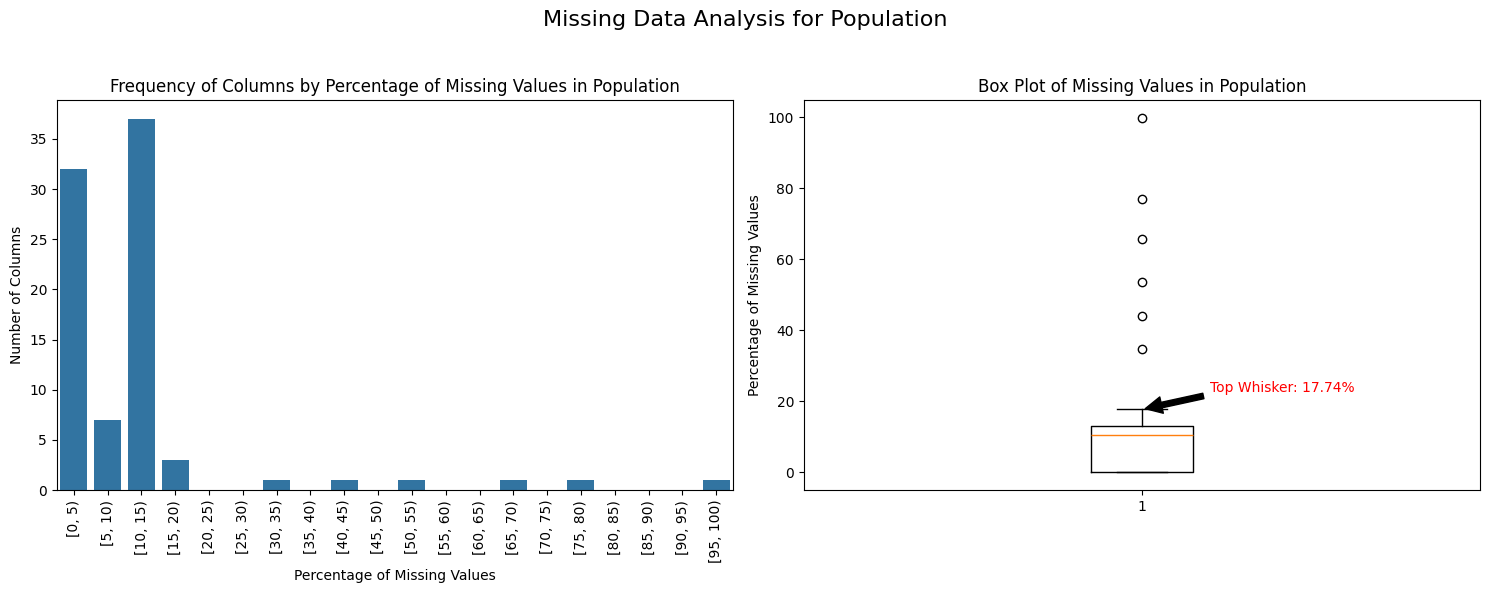

In [12]:
# Investigate patterns in the amount of missing data in each column.
def plot_missing_values_columns(df, df_name):
    missing_values = df.isnull().sum(axis=0) / df.shape[0] * 100
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    # Set the main title for the figure
    fig.suptitle(f'Missing Data Analysis for {df_name}', fontsize=16)
    
    # Count plot with expanded bin size
    bins = range(0, 101, 5)  # Bins from 0 to 100 with a step of 5
    missing_values_binned = pd.cut(missing_values, bins=bins, right=False)
    sns.countplot(x=missing_values_binned, ax=axes[0])
    axes[0].set_title(f'Frequency of Columns by Percentage of Missing Values in {df_name}')
    axes[0].set_xlabel('Percentage of Missing Values')
    axes[0].set_ylabel('Number of Columns')
    axes[0].tick_params(axis='x', rotation=90)
    
    # Box plot
    boxplot = axes[1].boxplot(missing_values, vert=True)
    axes[1].set_title(f'Box Plot of Missing Values in {df_name}')
    axes[1].set_ylabel('Percentage of Missing Values')
    
    # Annotate the top whisker value
    whiskers = boxplot['whiskers']
    top_whisker = whiskers[1].get_ydata()[1]
    axes[1].annotate(f'Top Whisker: {top_whisker:.2f}%', 
                     xy=(1, top_whisker), 
                     xytext=(1.1, top_whisker + 5),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, 
                     color='red')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

plot_missing_values_columns(population_cleaned, "Population")

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)
# Remove columns with more than 32% missing values as calculated. In practice, this is displayed as 17.5% in the box plot becasue there is no column with 17.74-32% missing values.
def identify_outliers_columns(df, threshold):
    missing_values = df.isnull().sum() / df.shape[0] * 100
    outliers = missing_values[missing_values > threshold].index
    return outliers

# Identify outliers
outlier_columns = identify_outliers_columns(population_cleaned, 32)

# Drop outliers
population_cleaned_v2 = population_cleaned.drop(outlier_columns, axis=1)

# Print shape of population dataset
print("Population before after removing outliers:", population_cleaned.shape)
print("Population shape after removing outliers:", population_cleaned_v2.shape)
print("Outlier columns removed:", outlier_columns.tolist())

Population before after removing outliers: (891221, 85)
Population shape after removing outliers: (891221, 79)
Outlier columns removed: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column

There were six columns present that had more than 1.5 times the IQR range of missing values in the population dataset. This dataset had the lower IQR, so it was used as the benchmark. That said, there is still a high perponderence of columns with missing data. It is also interesting that in the original data, missing data percentages repeated themself which implies it was part of the data collection process. 

The removed columns were:
| Index   | Feature        | Missing    | Percentage |
|---------|----------------|------------|------------|
| 40      | TITEL_KZ       | 889061     | 99.757636% |
| 0       | AGER_TYP       | 685843     | 76.955435% |
| 47      | KK_KUNDENTYP   | 584612     | 65.596749% |
| 64      | KBA05_BAUMAX   | 476524     | 53.468668% |
| 11      | GEBURTSJAHR    | 392318     | 44.020282% |
| 43      | ALTER_HH       | 310267     | 34.813699% |

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
def analyze_missing_values_rows(df, df_name):
    # Identify missing or unknown data values and convert them to NaNs.
    # Count the number of missing values in each row
    missing_population = df.isnull().sum(axis=1).reset_index()
    missing_population.columns = ['Row', 'Missing Values']
    
    # Calculate the percentage of missing values for each row
    missing_population['Percentage'] = (missing_population['Missing Values'] / df.shape[1]) * 100
    
    print(f"Missing values in {df_name}:")
    display(missing_population.sort_values(by='Missing Values', ascending=False).head(10))

    # Count the number of rows in missing_population where missing values is greater than 0
    print(f"Rows with Missing Values in {df_name}: {missing_population[missing_population['Missing Values'] > 0].shape[0]}")
    print(f"Total Missing Values in {df_name}: {missing_population['Missing Values'].sum():,}")
    print(f"Percentage of Missing Values in {df_name}: {(missing_population['Missing Values'].sum()/(df.shape[0]*df.shape[1]))*100:.2f}%")

    # Calculate and print the 25th, 50th, and 75th percentiles of missing values
    percentiles = missing_population['Percentage'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
    print(f"25th Percentile of Missing Values in {df_name}: {percentiles[0.25]:.2f}%")
    print(f"50th Percentile of Missing Values in {df_name}: {percentiles[0.50]:.2f}%")
    print(f"75th Percentile of Missing Values in {df_name}: {percentiles[0.75]:.2f}%")
    print(f"90th Percentile of Missing Values in {df_name}: {percentiles[0.90]:.2f}%")
    print(f"95th Percentile of Missing Values in {df_name}: {percentiles[0.95]:.2f}%")
    print(f"99th Percentile of Missing Values in {df_name}: {percentiles[0.99]:.2f}%")

    # Calculate cutoff for outliers
    iqr = percentiles[0.75] - percentiles[0.25]
    lower_bound = percentiles[0.25] - 1.5 * iqr
    upper_bound = percentiles[0.75] + 1.5 * iqr
    print(f"Lower Bound for Outliers in {df_name}: {lower_bound:.2f}%")
    print(f"Upper Bound for Outliers in {df_name}: {upper_bound:.2f}%")

analyze_missing_values_rows(population_cleaned_v2, "Population")

Missing values in Population:


,Row,Missing Values,Percentage
732775,732775,49,62.025316
643174,643174,49,62.025316
472919,472919,48,60.759494
345274,345274,47,59.493671
299868,299868,47,59.493671
582092,582092,47,59.493671
681255,681255,47,59.493671
818343,818343,47,59.493671
582109,582109,47,59.493671
439981,439981,47,59.493671


Rows with Missing Values in Population: 268012
Total Missing Values in Population: 5,035,304
Percentage of Missing Values in Population: 7.15%
25th Percentile of Missing Values in Population: 0.00%
50th Percentile of Missing Values in Population: 0.00%
75th Percentile of Missing Values in Population: 3.80%
90th Percentile of Missing Values in Population: 43.04%
95th Percentile of Missing Values in Population: 59.49%
99th Percentile of Missing Values in Population: 59.49%
Lower Bound for Outliers in Population: -5.70%
Upper Bound for Outliers in Population: 9.49%


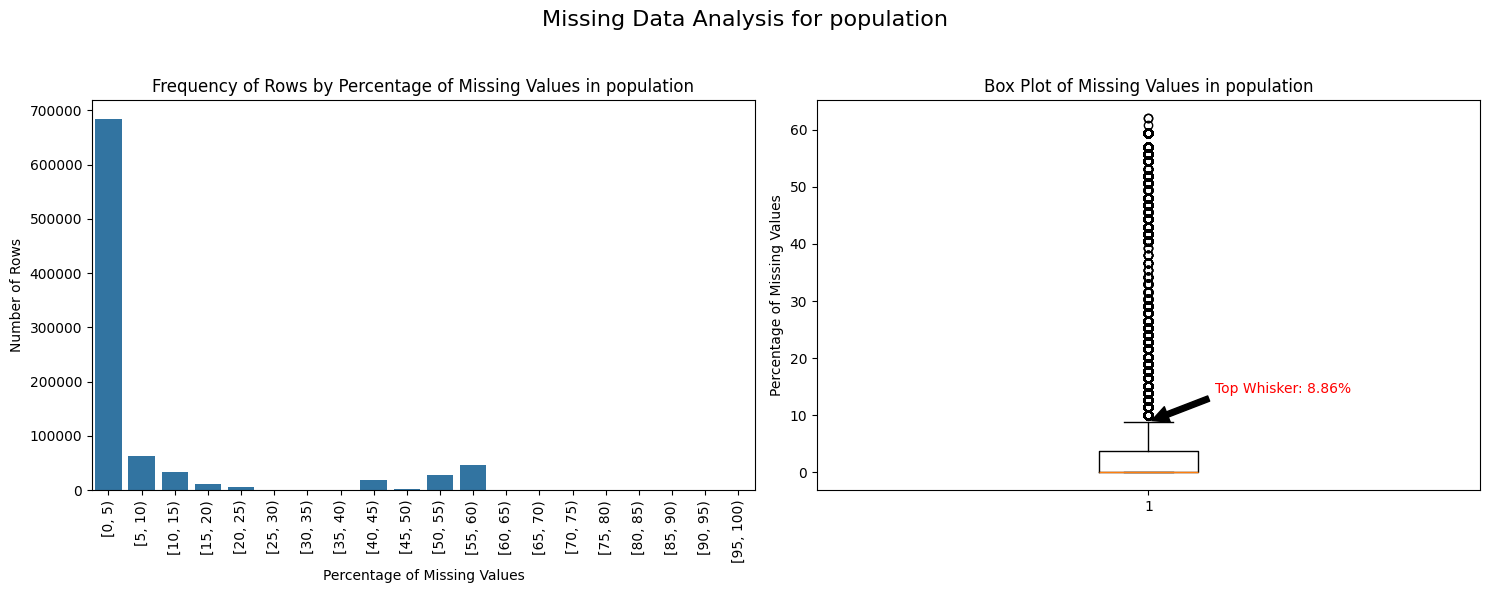

In [15]:
# How much data is missing in each row of the dataset?
# Investigate patterns in the amount of missing data in each row using seaborn's countplot.
# Investigate patterns in the amount of missing data in each row.
def plot_missing_values_rows(df, df_name):
    missing_values = df.isnull().sum(axis=1) / df.shape[1] * 100
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    # Set the main title for the figure
    fig.suptitle(f'Missing Data Analysis for {df_name}', fontsize=16)
    
    # Count plot with expanded bin size
    bins = range(0, 101, 5)  # Bins from 0 to 100 with a step of 5
    missing_values_binned = pd.cut(missing_values, bins=bins, right=False)
    sns.countplot(x=missing_values_binned, ax=axes[0])
    axes[0].set_title(f'Frequency of Rows by Percentage of Missing Values in {df_name}')
    axes[0].set_xlabel('Percentage of Missing Values')
    axes[0].set_ylabel('Number of Rows')
    axes[0].tick_params(axis='x', rotation=90)
    
    # Box plot
    boxplot = axes[1].boxplot(missing_values, vert=True)
    axes[1].set_title(f'Box Plot of Missing Values in {df_name}')
    axes[1].set_ylabel('Percentage of Missing Values')
    
    # Annotate the top whisker value
    whiskers = boxplot['whiskers']
    top_whisker = whiskers[1].get_ydata()[1]
    axes[1].annotate(f'Top Whisker: {top_whisker:.2f}%', 
                     xy=(1, top_whisker), 
                     xytext=(1.1, top_whisker + 5),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, 
                     color='red')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()

plot_missing_values_rows(population_cleaned_v2, "population")


In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def remove_outliers_rows(df, threshold):
    missing_values = df.isnull().sum(axis=1) / df.shape[1] * 100
    outliers = missing_values[missing_values > threshold].index
    df_cleaned = df.drop(outliers, axis=0)
    df_outliers = df.loc[outliers]
    return df_cleaned, df_outliers, outliers

population_cleaned_v3, population_cleaned_v3_outliers, outlier = remove_outliers_rows(population_cleaned_v2, 32)

# Print shape of population and customers datasets
print("Population shape before removing outliers:", population_cleaned_v2.shape)
print("Population shape after removing outliers:", population_cleaned_v3.shape)
print("Population shape of outliers:", population_cleaned_v3_outliers.shape)


Population shape before removing outliers: (891221, 79)
Population shape after removing outliers: (797961, 79)
Population shape of outliers: (93260, 79)


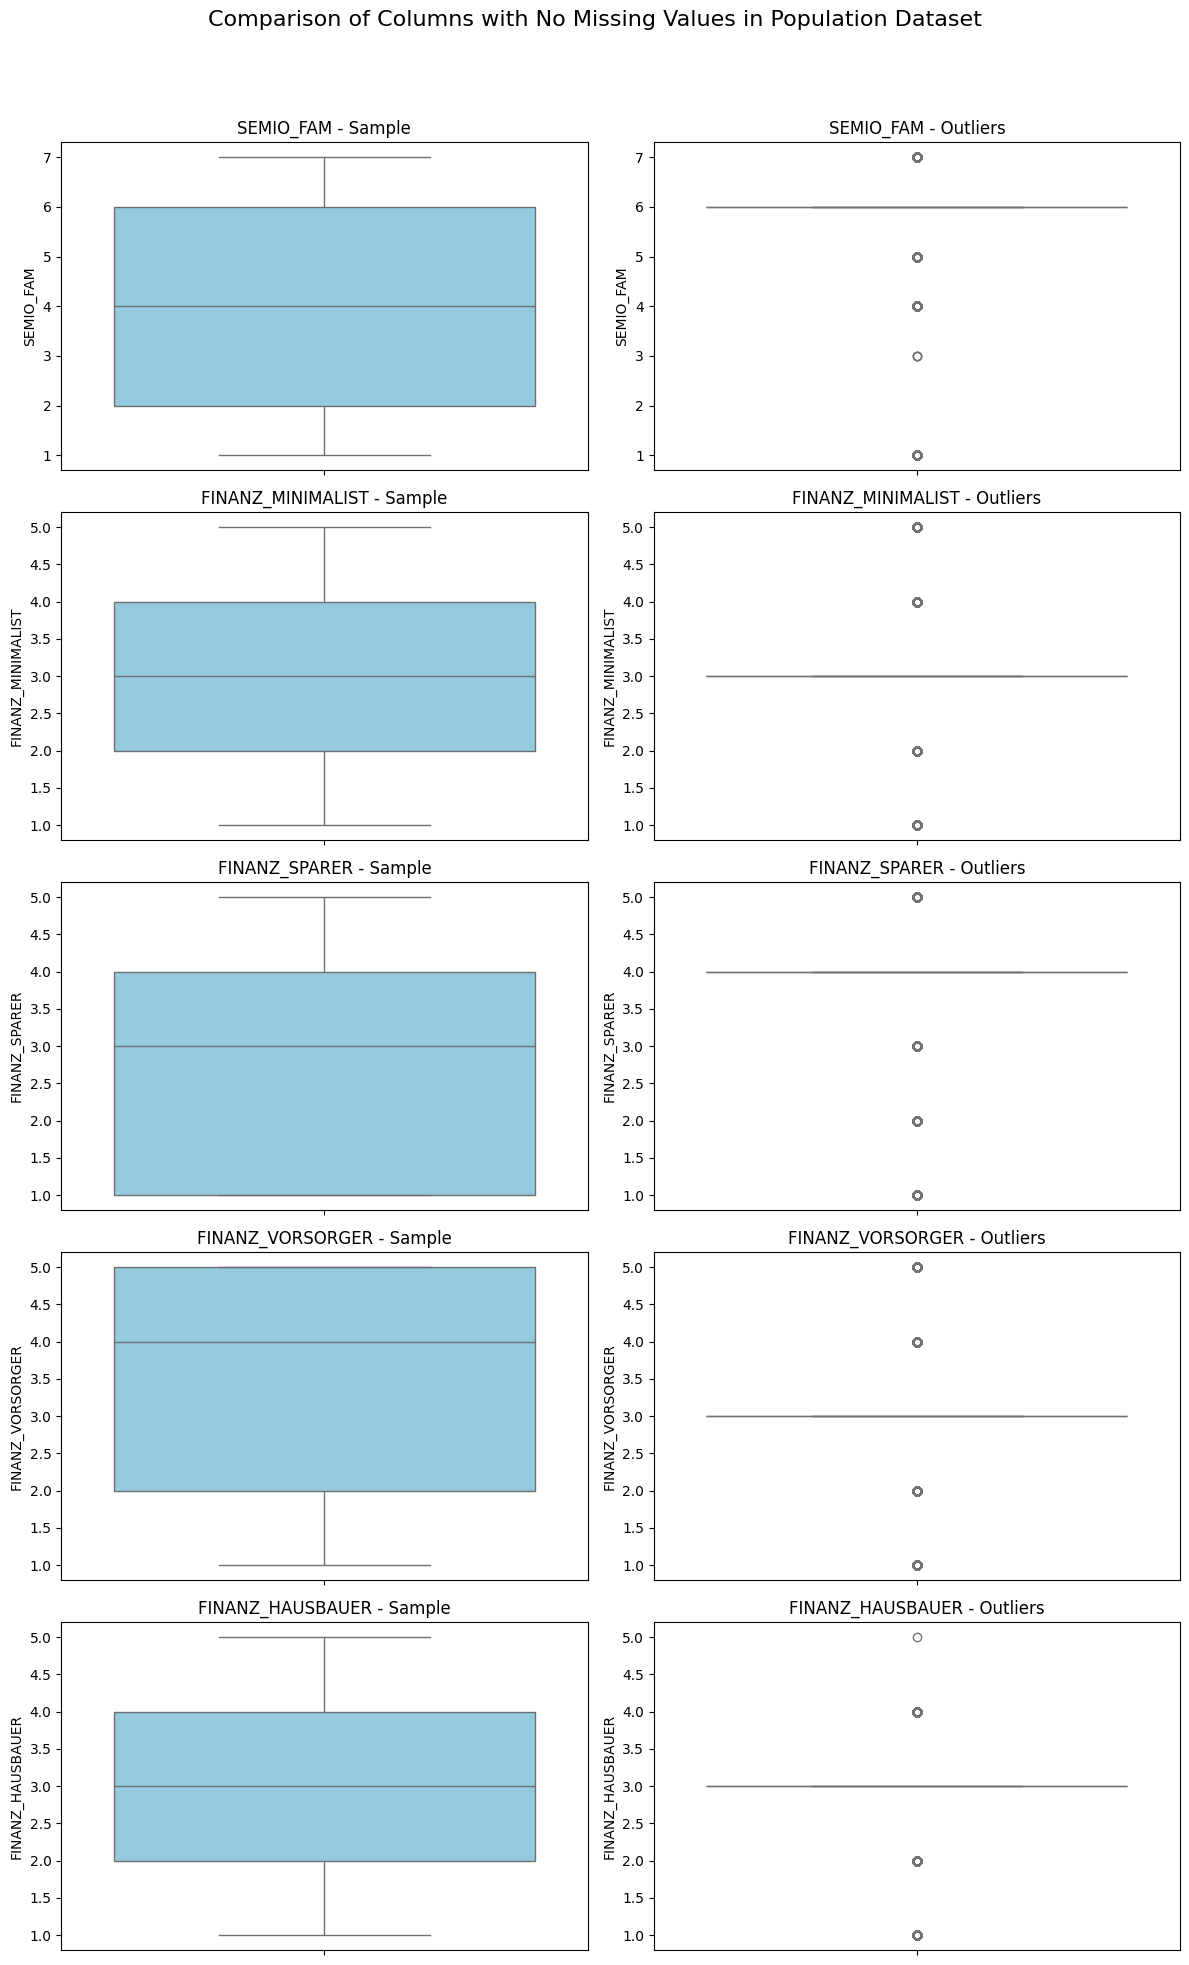

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Select 5 columns with no missing values from the population_cleaned dataset
no_missing_columns = population_cleaned_v2.columns[population_cleaned_v2.isnull().sum() == 0]
columns = random.sample(list(no_missing_columns), 5)

# Print box plot for the selected columns comparing the two datasets
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))
fig.suptitle('Comparison of Columns with No Missing Values in Population Dataset', fontsize=16)

for i, column in enumerate(columns):
    sns.boxplot(y=column, data=population_cleaned_v3, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'{column} - Sample')
    sns.boxplot(y=column, data=population_cleaned_v3_outliers, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'{column} - Outliers')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data with missing values appear to be signifigantly different from those with full data, with all 5 random columns selected having zero interquartile range. This seems to point to a series flaw in the data with high numbers of missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
features['type'].value_counts()


type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Remove outlier attributes from features dataset
features_cleaned = features[~features['attribute'].isin(outlier_columns)]

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary = []
binary_nn = []
multi_level = []


for attribute in features_cleaned[features_cleaned['type'] == 'categorical']['attribute']:
    if population_cleaned_v3[attribute].nunique() == 2:
        if pd.api.types.is_numeric_dtype(population_cleaned_v3[attribute]):
            binary.append(attribute)
        else:
            binary_nn.append(attribute)
    elif population_cleaned_v3[attribute].nunique() > 2:
        multi_level.append(attribute)

print("There are",len(binary),"Binary Categorical Variables:", binary)
print("There are",len(binary_nn),"Binary Categorical Variables with Non-Numeric Values:", binary_nn)
print("There are",len(multi_level),"Multi-Level Categorical Variables:", multi_level)

There are 4 Binary Categorical Variables: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
There are 1 Binary Categorical Variables with Non-Numeric Values: ['OST_WEST_KZ']
There are 13 Multi-Level Categorical Variables: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [21]:
def re_encode_categorical(df, binary_nn, multi_level):
    df_copy = df.copy()
    
    # Combine binary_nn and multi_level for one-hot encoding
    columns_to_encode = binary_nn + multi_level
    
    # Initialize OneHotEncoder
    encoder = OneHotEncoder(categories='auto', drop='first')
    
    # Fit and transform the specified columns
    encoded_columns = encoder.fit_transform(df_copy[columns_to_encode])
    
    # Create a DataFrame with the encoded columns
    encoded_df = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))
    
    # Drop the original columns and concatenate the encoded columns
    df_copy.drop(columns=columns_to_encode, inplace=True)
    df_copy = pd.concat([df_copy, encoded_df], axis=1)
    
    return df_copy

# Example usage
population_cleaned_v4 = re_encode_categorical(population_cleaned_v3, binary_nn, multi_level)

In [22]:
display(population_cleaned_v4.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.

#### Discussion 1.2.1: Re-Encode Categorical Features

Of the 21 catagorical variables, 4 were binary, 1 was binary but not numeric, and 13 were mutli-level. All were preserved and converted to either numberic binary or one-hot encoded. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
# For features in features_cleaned dataset, identify the attributes that of 'mixed' type
mixed = features_cleaned[features_cleaned['type'] == 'mixed']['attribute']
print("Mixed Attributes:", mixed.tolist())

Mixed Attributes: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [24]:
# Function to parse variable definitions
def parse_variable_definitions(variables, file_path):
    with open(file_path, 'r') as file:
        dictionary = file.readlines()

    parsed_data = []
    for var in variables:
        start_collecting = False
        for line in dictionary:
            if var in line:
                start_collecting = True
            elif start_collecting:
                # Stop if the next variable definition starts
                if any(v in line for v in variables) or line.startswith("#"):
                    break
                # Only collect lines that contain value-definition pairs
                line = line.strip()
                if line.startswith("- "):
                    value, definition = line.split(':', 1)
                    value = value.strip().replace("- ", "").replace(".", "").replace(" ", "")
                    definition = definition.strip()
                    parsed_data.append([var, value, definition])
    return pd.DataFrame(parsed_data, columns=["Variable", "Value", "Definition"])

# Parse the definitions into a structured DataFrame
parsed_definitions_df = parse_variable_definitions(mixed, 'Data_Dictionary.md')

In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Print the definitions for PRAEGENDE_JUGENDJAHRE from the parsed_definitions_df
display(parsed_definitions_df[parsed_definitions_df['Variable'] == 'PRAEGENDE_JUGENDJAHRE'])

,Variable,Value,Definition
52,PRAEGENDE_JUGENDJAHRE,-1,unknown
53,PRAEGENDE_JUGENDJAHRE,0,unknown
54,PRAEGENDE_JUGENDJAHRE,1,"40s - war years (Mainstream, E+W)"
55,PRAEGENDE_JUGENDJAHRE,2,"40s - reconstruction years (Avantgarde, E+W)"
56,PRAEGENDE_JUGENDJAHRE,3,"50s - economic miracle (Mainstream, E+W)"
57,PRAEGENDE_JUGENDJAHRE,4,50s - milk bar / Individualisation (Avantgarde...
58,PRAEGENDE_JUGENDJAHRE,5,"60s - economic miracle (Mainstream, E+W)"
59,PRAEGENDE_JUGENDJAHRE,6,60s - generation 68 / student protestors (Avan...
60,PRAEGENDE_JUGENDJAHRE,7,60s - opponents to the building of the Wall (A...
61,PRAEGENDE_JUGENDJAHRE,8,"70s - family orientation (Mainstream, E+W)"


In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def extract_praegende(df, parsed_definitions_df):
    # Filter the relevant definitions
    praegende_definitions = parsed_definitions_df[parsed_definitions_df['Variable'] == 'PRAEGENDE_JUGENDJAHRE'].copy()
    praegende_definitions.loc[:, 'value'] = praegende_definitions['Value'].astype(float)
    
    # Create generation and movement columns in parsed_definitions_df
    praegende_definitions.loc[:, 'generation'] = praegende_definitions['Definition'].apply(
        lambda x: np.nan if 'unknown' in x else int(x.split(' ')[0][0])
    )
    praegende_definitions.loc[:, 'movement'] = praegende_definitions['Definition'].apply(
        lambda x: 0 if 'Mainstream' in x else (1 if 'Avantgarde' in x else np.nan)
    )
    
    # Create dictionaries for generation and movement
    generation_dict = praegende_definitions.set_index('value')['generation'].to_dict()
    movement_dict = praegende_definitions.set_index('value')['movement'].to_dict()
    
    # Create new columns for generation and movement
    df_copy = df.copy()
    df_copy.loc[:, 'pj_generation'] = df_copy['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)
    df_copy.loc[:, 'pj_movement'] = df_copy['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    # Drop intermediate columns
    df_copy.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    
    return df_copy, generation_dict, movement_dict

# Apply the function to the DataFrame
population_cleaned_v5, generation_dict, movement_dict = extract_praegende(population_cleaned_v4, parsed_definitions_df)

In [27]:
display(population_cleaned_v5['CAMEO_INTL_2015'].unique())

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [28]:
# Break down "CAMEO_INTL_2015" into two new variables and drop the original column.
def extract_cameo(df):
    # Create wealth and life stage columns
    df_new= df.copy()
    df_new.loc[:, 'wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if pd.notnull(x) else x)
    df_new.loc[:, 'life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if pd.notnull(x) else x)
    
    # Drop original column
    #df_new.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    
    return df_new

population_cleaned_v6 = extract_cameo(population_cleaned_v5)

In [29]:
# Drop LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX' columns. 
population_cleaned_v7 = population_cleaned_v6.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I Dropped all variables outside of the two caputred above as none were monotic, several conflated features, and were captured by other very multi-collinear variables. See full notes below:
- LP_LEBENSPHASE_FEIN - Complex mix of income, marital status, age, and childrearing. Captured in other attributes. Drop. 
- LP_LEBENSPHASE_GROB - Mix of income, marital status, age, and childrearing. Captured in other attributes. Drop.
- WOHNLAGE - Neighborhood Quality. This appears to be scorable from 5 to 1 with one being the best and 7/8 as rural flags. Captured in REGIOTYP on not monotonic. Drop. 
- PLZ8_BAUMAX - Degree of density. Captured in PLZ8_ANTG4 and not monotic as it includes business entities. - Drop.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df, missing_values, outlier_columns, row_threshold, columns_to_encode, generation_dict, movement_dict):
    # Replace missing or unknown values with NaN
    for index, row in missing_values.iterrows():
        attribute = row['attribute']
        missing_or_unknown = row['missing_or_unknown']
        # Replace the values in the copied DataFrame that match the missing_or_unknown values with NaN
        df[attribute] = df[attribute].replace(missing_or_unknown, np.nan)

    # Remove outlier columns
    df = df.drop(outlier_columns, axis=1)

    # Remove outlier rows
    missing_value_count = df.isnull().sum(axis=1) / df.shape[1] * 100
    outliers = missing_value_count[missing_value_count > row_threshold].index
    df_outliers = df.loc[outliers]
    df = df.drop(outliers, axis=0)

    # Re-encode categorical variables
    encoder = OneHotEncoder(categories='auto', drop='first')
    encoded_columns = encoder.fit_transform(df[columns_to_encode])
    encoded_df = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))
    df.drop(columns=columns_to_encode, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)

    # Extract PRAEGENDE_JUGENDJAHRE and 
    # Create new columns for generation and movement
    df.loc[:, 'pj_generation'] = df['PRAEGENDE_JUGENDJAHRE'].map(generation_dict)
    df.loc[:, 'pj_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)

    # Extract CAMEO_INTL_2015
    df.loc[:, 'wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if pd.notnull(x) else x)
    df.loc[:, 'life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if pd.notnull(x) else x)
    df.drop(columns=['CAMEO_INTL_2015'], inplace=True)

    return df, df_outliers

# Apply the cleaning function to the population dataset
population_cleaned, population_outliers = clean_data(population, missing_values, outlier_columns, 32, binary_nn + multi_level, generation_dict, movement_dict)

In [33]:
display(population_cleaned.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan,pj_generation,pj_movement,wealth,life_stage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
analyze_missing_values(population_cleaned, "Population Cleaned")
print(population_cleaned.shape)


Missing values in Population Cleaned:


,Feature,Missing Values,Percentage
51,REGIOTYP,148673,16.859809
48,KKK,148673,16.859809
32,W_KEIT_KIND_HH,143101,16.227933
10,LP_LEBENSPHASE_FEIN,133991,15.194842
11,LP_LEBENSPHASE_GROB,131105,14.867564
43,KBA05_GBZ,123922,14.052997
42,KBA05_ANTG4,123922,14.052997
49,MOBI_REGIO,123922,14.052997
41,KBA05_ANTG3,123922,14.052997
40,KBA05_ANTG2,123922,14.052997


Rows with Missing Values in Population Cleaned: 193
Total Missing Values in Population Cleaned: 17,066,494
Percentage of Missing Values in Population Cleaned: 10.03%
25th Percentile of Missing Values in Population Cleaned: 9.51%
50th Percentile of Missing Values in Population Cleaned: 9.51%
75th Percentile of Missing Values in Population Cleaned: 9.51%
90th Percentile of Missing Values in Population Cleaned: 12.15%
95th Percentile of Missing Values in Population Cleaned: 14.05%
99th Percentile of Missing Values in Population Cleaned: 16.28%
Lower Bound for Outliers in Population Cleaned: 9.51%
Upper Bound for Outliers in Population Cleaned: 9.51%
(881819, 193)


### Missing value strategy
Given that all rows have some missing values and it represents 10% of the dataset, I will take the mode of each column and impute the missing values. 

In [35]:
def impute_missing_values(df):
    imputer = SimpleImputer(strategy='most_frequent')
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns), imputer

# Apply the imputer to the population dataset
population_imputed, imputer = impute_missing_values(population_cleaned)

In [36]:
# Check the dataset after imputation for missing values
analyze_missing_values(population_imputed, "Population Imputed")

Missing values in Population Imputed:


,Feature,Missing Values,Percentage
0,ALTERSKATEGORIE_GROB,0,0.0
97,LP_FAMILIE_FEIN_nan,0,0.0
123,SHOPPER_TYP_3.0,0,0.0
124,SHOPPER_TYP_nan,0,0.0
125,ZABEOTYP_2,0,0.0
126,ZABEOTYP_3,0,0.0
127,ZABEOTYP_4,0,0.0
128,ZABEOTYP_5,0,0.0
129,ZABEOTYP_6,0,0.0
130,GEBAEUDETYP_2.0,0,0.0


Rows with Missing Values in Population Imputed: 0
Total Missing Values in Population Imputed: 0
Percentage of Missing Values in Population Imputed: 0.00%
25th Percentile of Missing Values in Population Imputed: 0.00%
50th Percentile of Missing Values in Population Imputed: 0.00%
75th Percentile of Missing Values in Population Imputed: 0.00%
90th Percentile of Missing Values in Population Imputed: 0.00%
95th Percentile of Missing Values in Population Imputed: 0.00%
99th Percentile of Missing Values in Population Imputed: 0.00%
Lower Bound for Outliers in Population Imputed: 0.00%
Upper Bound for Outliers in Population Imputed: 0.00%


In [37]:
# Apply feature scaling to the general population demographics data.
def scale_data(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    return df_scaled, scaler

# Apply the scaling function to the population dataset
population_scaled, scaler = scale_data(population_imputed)

### Discussion 2.1: Apply Feature Scaling
Given that all rows had some missing values and missing values represented 10% of the dataset, I inputed missing values rather than dropping the samples. Additionally, used the mode (strategy='most_frequent') of each column to impute the missing values, as there were several catagorical variables so a simple mean did not seem appropriate. Ideally, I would have taken the mean of dummy variables and the mode of catagorical variables. As suggested, I used the standard scaler to standardize the data. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.
def train_pca(df, n_components=None):
    pca = PCA(n_components, random_state=42)
    df_pca = pca.fit_transform(df)
    return pca, df_pca

# Apply PCA to the population dataset
pca_int, pop_transformed_int = train_pca(population_scaled)


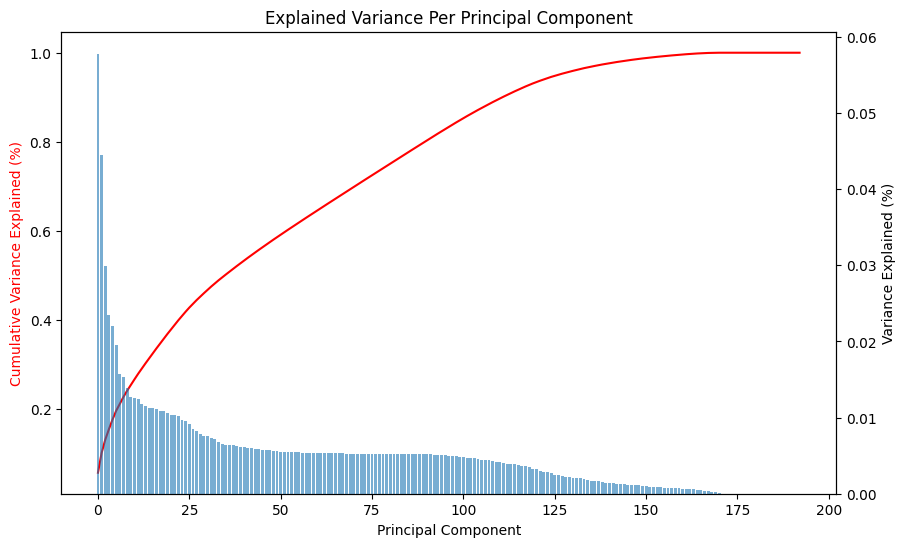

In [39]:
# Investigate the variance accounted for by each principal component.
# Use a bar plot to visualize the explained variance of each principal component.
def plot_pca_variance(pca):
    n_components = pca.n_components_
    ind = np.arange(n_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    ax1 = plt.subplot(111)
    cumvals = np.cumsum(vals)
    
    ax1.plot(ind, cumvals, 'r-')
    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Cumulative Variance Explained (%)", color='r')
    
    ax2 = ax1.twinx()
    ax2.bar(ind, vals, alpha=0.6)
    ax2.set_ylabel("Variance Explained (%)")
    
    plt.title('Explained Variance Per Principal Component')
    plt.show()

plot_pca_variance(pca_int)


In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, pop_transformed = train_pca(population_scaled,110)

### Discussion 2.2: Perform Dimensionality Reduction
The variance reduced linear from about ~40 features through ~110 features, so depending on our need there was an argument to select anywhere within that range. Assuming we are optimizing for accuracy, I selected ~110 features. Given are large popnderence of one-hot encoded variables, it somewhat makes sense this number would be high. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

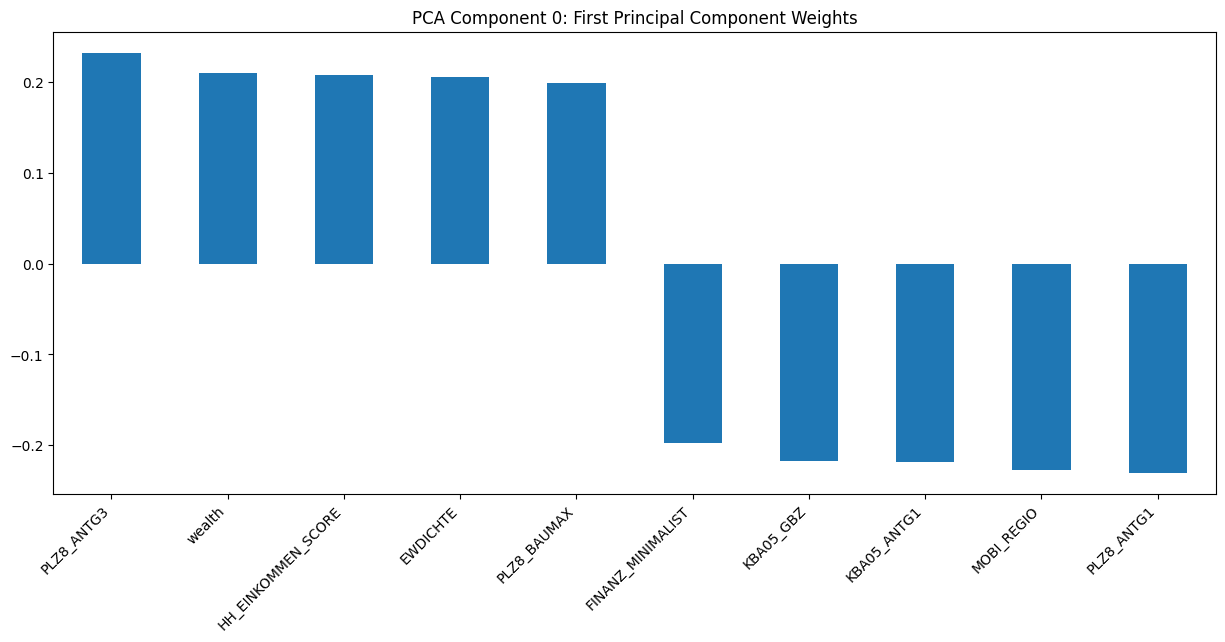

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_and_plot_weights(pca, df, component, title=None):
    components = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component]
    components.sort_values(ascending=False, inplace=True)
    # Sort components by their values
    sorted_components = components.sort_values(ascending=False)
    
    # Select the first 5 largest positive and last 5 largest negative components
    selected_components = pd.concat([sorted_components.head(5), sorted_components.tail(5)])
    
    # Plot the selected components
    selected_components.plot(kind='bar', figsize=(15, 6))
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    
    plt.show()


map_and_plot_weights(pca, population_scaled, 0,'PCA Component 0: First Principal Component Weights')

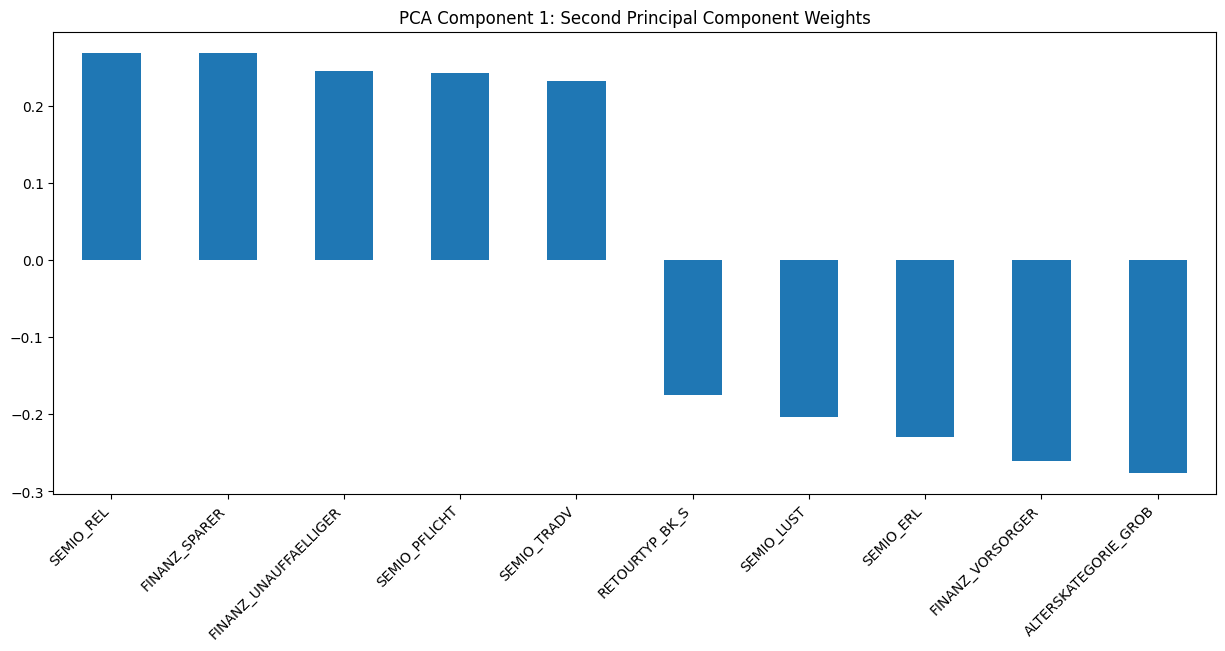

In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_and_plot_weights(pca, population_scaled, 1,'PCA Component 1: Second Principal Component Weights')


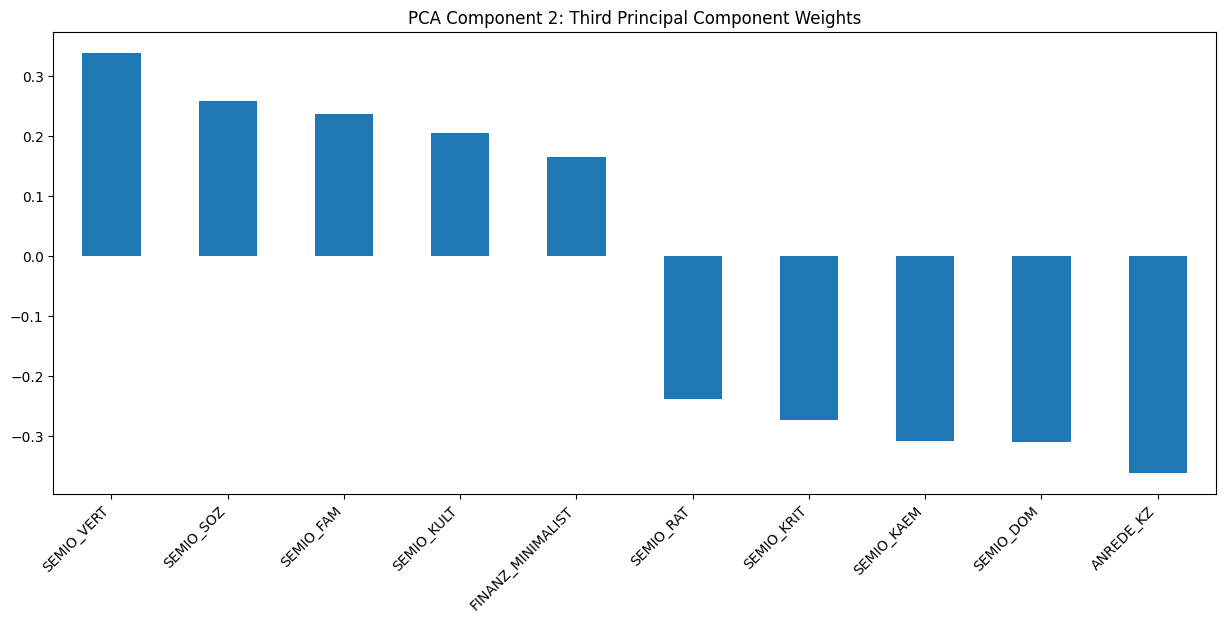

In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_and_plot_weights(pca, population_scaled, 2,'PCA Component 2: Third Principal Component Weights')


### Discussion 2.3: Interpret Principal Components

- PC0 - This component is related to high urban density and low wealth. Pointing to areas with low afluence apartment dwellers. 
- PC1 - This component is based primarily on personality typology and finance with it being a religious, duty bound, traditional group who are high savers. 
- PC2 - This component is related to groups defined by sociality, family, and openess. They place little emphasis on material posesions. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
# Over a number of different cluster counts...
scores = []
for i in range(5, 21):
    # run k-means clustering on the data and...
    km_int = KMeans(n_clusters=i, random_state=42)
    model = km_int.fit(pop_transformed)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(pop_transformed))
    scores.append(score)
    print(f"Cluster Count: {i}, Score: {score:.2f}")

Cluster Count: 5, Score: 137341016.56
Cluster Count: 6, Score: 136018929.25
Cluster Count: 7, Score: 133875123.62
Cluster Count: 8, Score: 131882856.28
Cluster Count: 9, Score: 130779542.25
Cluster Count: 10, Score: 129996863.75
Cluster Count: 11, Score: 129448500.77
Cluster Count: 12, Score: 129584574.76
Cluster Count: 13, Score: 128553377.25
Cluster Count: 14, Score: 124872256.22
Cluster Count: 15, Score: 124330559.03
Cluster Count: 16, Score: 123578580.21
Cluster Count: 17, Score: 122780346.89
Cluster Count: 18, Score: 122009500.59
Cluster Count: 19, Score: 121235901.66
Cluster Count: 20, Score: 120445638.92


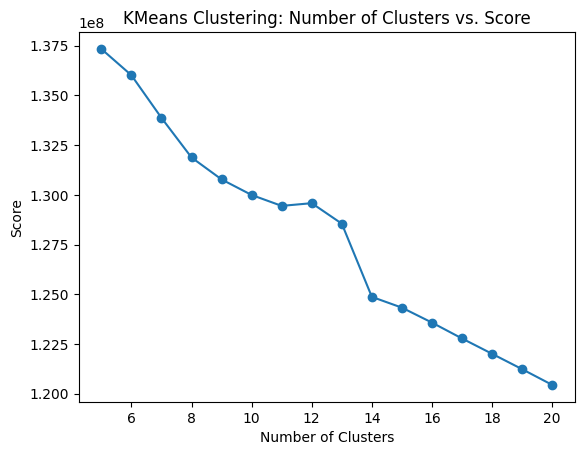

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(5, 21), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('KMeans Clustering: Number of Clusters vs. Score')
plt.show()


In [46]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
km = KMeans(n_clusters=14, random_state=42)
population_clusters = km.fit_predict(pop_transformed)

### Discussion 3.1: Apply Clustering to General Population

I selected 14 clusters as this was clusters as this represented a sharp decline before the gradual linear decrease. 20 would also have been in consideration. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [52]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply the cleaning function to the customers dataset
customers_cleaned, customers_outliers = clean_data(customers, missing_values, outlier_columns, 32, binary_nn + multi_level, generation_dict, movement_dict)

# Ensure that the customers dataset has the same columns as the population dataset
missing_columns = set(population_scaled.columns) - set(customers_cleaned.columns)
for column in missing_columns:
    customers_cleaned[column] = 0


# Ensure that the customers dataset's columns are in the same order as the population dataset
customers_cleaned = customers_cleaned[population_scaled.columns]
    
# Apply the imputer to the customers dataset
customers_imputed = pd.DataFrame(imputer.transform(customers_cleaned), columns=customers_cleaned.columns)

# Apply the scaling function to the customers dataset
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed), columns=customers_imputed.columns)


In [53]:
# Apply PCA to the customers dataset
cust_transformed = pca.transform(customers_scaled)

# Apply KMeans clustering to the customers dataset
customers_clusters = km.predict(cust_transformed)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

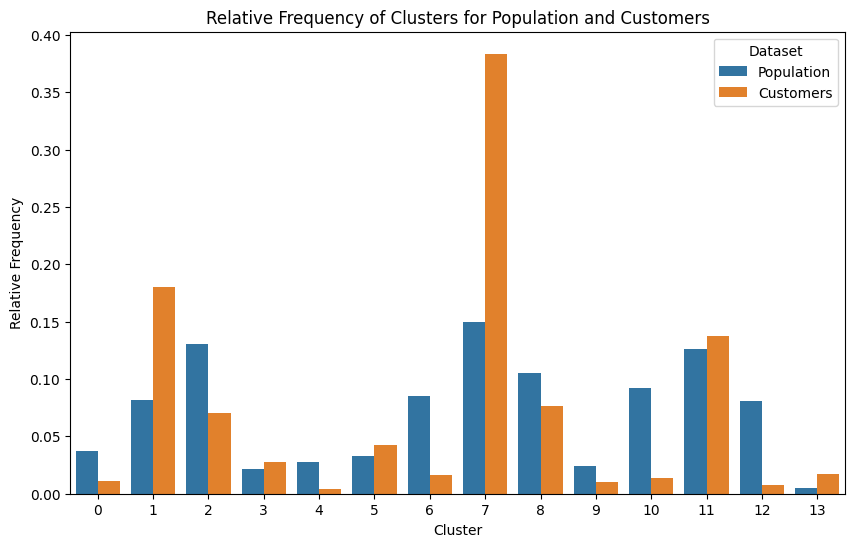

In [54]:
# Calculate the relative frequencies for each cluster
population_cluster_counts = pd.Series(population_clusters).value_counts(normalize=True).sort_index()
customers_cluster_counts = pd.Series(customers_clusters).value_counts(normalize=True).sort_index()

# Combine the relative frequencies into a single DataFrame
relative_frequencies_df = pd.DataFrame({
    'Population': population_cluster_counts,
    'Customers': customers_cluster_counts
}).reset_index().melt(id_vars='index', var_name='Dataset', value_name='Relative Frequency')

# Rename the 'index' column to 'Cluster'
relative_frequencies_df.rename(columns={'index': 'Cluster'}, inplace=True)


# Create the relative frequency plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=relative_frequencies_df, x='Cluster', y='Relative Frequency', hue='Dataset')
plt.title('Relative Frequency of Clusters for Population and Customers')
plt.xlabel('Cluster')
plt.ylabel('Relative Frequency')
plt.legend(title='Dataset')
plt.show()

In [55]:
def component_exploration(cluster, n_top_components=5):
    # Get the PCA components for the specified cluster
    cluster_center = km.cluster_centers_[cluster]
    pca_components = pca.components_
    
    # Calculate the contribution of each PCA component to the cluster center
    component_contributions = np.dot(cluster_center, pca_components)
    
    # Create a DataFrame with the PCA components and their contributions
    components_df = pd.DataFrame({
        'component': range(len(component_contributions)),
        'contribution': component_contributions
    })
    
    # Sort the DataFrame by absolute contribution values to get the top components
    top_components_df = components_df.reindex(components_df['contribution'].abs().sort_values(ascending=False).index).head(n_top_components)

    
    display(top_components_df)

# Investigate the top components for a specific cluster
component_exploration(12)

,component,contribution
2,2,-1.457266
21,21,1.400309
0,0,-1.165101
3,3,1.149576
25,25,1.134283


In [56]:
def feature_exploration(cluster):
    weights = scaler.inverse_transform([pca.inverse_transform(km.cluster_centers_)[cluster]])
    weights_df = pd.DataFrame(weights, columns=population_cleaned.columns).T
    weights_df.reset_index(inplace=True)
    weights_df.columns = ['feature', 'weight']
    return weights_df

In [57]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 7 is overrepresented in the customer data
weights_df_7 = feature_exploration(7)


In [58]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Clusters 1, 6, 10, and 12 are underrepresented in the customer data

weights_df_1 = feature_exploration(1)
weights_df_6 = feature_exploration(6)
weights_df_10 = feature_exploration(10)
weights_df_12 = feature_exploration(12)

In [59]:
# Merge the weights DataFrames on the 'feature' column
dataframes = [weights_df_1, weights_df_6, weights_df_10, weights_df_12]

# Initialize the merged DataFrame with the first DataFrame
weights_merged = weights_df_7

# Merge each DataFrame in the list
for i, df in enumerate(dataframes):
    suffix = f'_{i+1}'
    weights_merged = weights_merged.merge(df, on='feature', suffixes=('', suffix))

weights_merged.columns = ['feature', 'weight_7', 'weight_1', 'weight_6', 'weight_10', 'weight_12']

# Add a column for the average and variance of the weights
weight_columns = ['weight_7', 'weight_1', 'weight_6', 'weight_10', 'weight_12']
weights_merged['sd'] = weights_merged[weight_columns].var(axis=1)/weights_merged[weight_columns].mean(axis=1)

# Format all weights to 2 decimal places
weights_merged = weights_merged.round(2)

display(weights_merged.sort_values(by='sd', ascending=False).head(45))

,feature,weight_7,weight_1,weight_6,weight_10,weight_12,sd
52,KBA13_ANZAHL_PKW,704.02,1350.58,683.52,738.64,529.53,125.69
34,ANZ_HAUSHALTE_AKTIV,2.64,0.67,5.11,3.33,15.80,6.46
10,LP_LEBENSPHASE_FEIN,20.59,1.41,15.93,16.16,8.45,4.59
17,SEMIO_VERT,5.97,2.02,6.33,2.57,2.25,1.19
24,SEMIO_KAEM,2.65,3.12,2.03,5.55,6.11,0.85
3,FINANZ_SPARER,1.67,1.01,4.18,3.89,4.28,0.79
39,KBA05_ANTG1,2.28,0.04,1.64,1.96,0.38,0.78
5,FINANZ_ANLEGER,1.88,1.02,3.82,4.31,4.14,0.73
13,SEMIO_SOZ,5.00,1.88,6.15,2.99,3.40,0.73
11,LP_LEBENSPHASE_GROB,6.15,1.96,5.01,5.12,3.04,0.68


### Discussion 3.3: Compare Customer Data to Demographics Data

I compared the overrepresented cluster (7), to the four other closers which were underepresented, to see where the biggest differences were. I also sorted by the standard deviation, to filter out factors which showed little variation. Looking specifically at clusters 1 and 10: 

Cluster 7 is *overrepresented* in the customers data compared to the overall German population. We can describe them as:
- Single parents (LP_LEBENSPHASE_FEIN = ~21)
- High savers (FINANZ_SPARER = 1.67)
- Average Income (HH_EINKOMMEN_SCORE=4.08)
- Later age: 46-60 years old (ALTERSKATEGORIE_GROB = 3.31)
- Male (ANREDE_KZ=1.09)

Cluster 10 is *underrepresented* in teh customers data compared to the overal German population them. We can describe them as:
- Average earner couples of higher age (LP_LEBENSPHASE_FEIN = ~16)
- Low savers (FINANZ_SPARER = 3.89)
- Average to lower income (HH_EINKOMMEN_SCORE=4.30)
- Young: ~30 years old (ALTERSKATEGORIE_GROB = 1.82)
- Female (ANREDE_KZ=1.98)


The mail order service appears popular amoung older single male parents with with moderate incomes. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.